## Imports

In [6]:
import numpy as np
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.preprocessing.environment import EnvironmentBuilder, Object2D, Point2D

In [7]:
import configparser
from typing import Any, Callable, Iterator, Optional
from matplotlib import pyplot as plt
from shapely import Polygon, Point
import shapely as spl
from bbtoolkit.data import Copyable
from bbtoolkit.data.configparser import EvalConfigParser
from shapely.validation import explain_validity

from bbtoolkit.preprocessing.environment import AbstractBuildingGeometryProcessor, GeometryFactory, GeometryParams, TrainingSpace


def plot_polygon(polygon: Polygon, ax: plt.Axes = None, **kwargs) -> plt.Figure:
    """
    Plots a given polygon on a matplotlib figure.

    Args:
        polygon (Polygon): The polygon to be plotted.
        ax (plt.Axes, optional): The axes object to draw the plot onto. If None, a new figure and axes object are created. Defaults to None.
        **kwargs: Arbitrary keyword arguments to be passed to the plot function.

    Returns:
        plt.Figure: The figure object with the plotted polygon.
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.plot(*polygon.exterior.xy, **kwargs)
    return fig


class EnvironmentBuilder(Copyable):
    """
    A class for building environments, defining training areas, objects, and creating configurations.

    Attributes:
        xy_min (float): Minimum value for X and Y axes of the environment.
        xy_max (float): Maximum value for X and Y axes of the environment.
        xy_train_min (float | tuple[float, float]): Minimum training area coordinates for X and Y (default is None).
        xy_train_max (float | tuple[float, float]): Maximum training area coordinates for X and Y (default is None).
        res (float): The resolution used for processing geometry data (default is 0.3).

    Methods:
        set_textures(self, n_textures: int) -> 'EnvironmentBuilder': Set the number of textures for the environment (Default is the same as number of objects).
        to_config(self) -> configparser.ConfigParser: Convert the environment configuration to a ConfigParser object.
        save(self, path: str): Save the environment configuration to a file at the specified path.
        load(cls, path: str) -> 'EnvironmentBuilder': Load an environment configuration from a file.
        add_object(self, *args: Object2D) -> 'EnvironmentBuilder': Add objects to the environment.
        plot(self, show: bool = False) -> plt.Figure: Plot the environment.

    Example:
        >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, res=0.5)
        >>> builder.set_textures(5).set_polygons(8)
        >>> builder.add_object(Object2D(x=(0, 1, 1, 0), y=(0, 0, 1, 1)))
        >>> fig = builder.plot(show=True)
    """
    def __init__(
        self,
        xy_min: float,
        xy_max: float,
        xy_train_min: float | tuple[float, float] = None,
        xy_train_max: float | tuple[float, float] = None,
        res: float =  0.3,
    ) -> None:
        # Initialize the EnvironmentBuilder with specified configurations
        self.xy_min = xy_min
        self.xy_max = xy_max

        if xy_train_max is None:
            self.x_train_max, self.y_train_max = self.xy_max, self.xy_max
        elif isinstance(xy_train_max, float):
            self.x_train_max, self.y_train_max = xy_train_max, xy_train_max
        else:
            self.x_train_max, self.y_train_max = xy_train_max
        if xy_train_min is None:
            self.x_train_min, self.y_train_min = self.xy_min, self.xy_min
        elif isinstance(xy_train_min, float):
            self.x_train_min, self.y_train_min = xy_train_min, xy_train_min
        else:
            self.x_train_min, self.y_train_min = xy_train_min

        self.res = res
        self.objects = list()
        self.n_textures = None

    def set_textures(self, n_textures: int) -> 'EnvironmentBuilder':
        """
        Set the number of textures for the environment.

        Args:
            n_textures (int): Number of textures to be set for the environment.

        Returns:
            EnvironmentBuilder: The instance of the EnvironmentBuilder with the number of textures set.
        """
        self.n_textures = n_textures
        return self

    def to_config(self) -> configparser.ConfigParser:
        """
        Generate a configuration parser instance containing environmental information.

        Returns:
            configparser.ConfigParser: Configuration parser instance representing the environmental boundaries,
            training area, building boundaries, and object vertices.

        The generated configuration contains sections representing different aspects of the environment:
        - 'ExternalSources': Empty sections for paths and variables.
        - 'GridBoundaries': Contains maximum and minimum XY coordinate and resolution details.
        - 'TrainingRectangle': Describes the training area coordinates.
        - 'BuildingBoundaries': Holds the maximum number of object points, number of objects, and
          counts of polygons and textures in the environment.

        The object-specific information is stored under individual sections 'Object{i}' for each object.
        Each object section contains 'n_vertices' and 'object_x'/'object_y' detailing the object's vertices.
        """
        parser = EvalConfigParser()
        parser.add_section('ExternalSources')
        parser.set('ExternalSources', 'paths', '')
        parser.set('ExternalSources', 'variables', '')

        parser.add_section('GridBoundaries')
        parser.set('GridBoundaries', 'max_xy', str(self.xy_max))
        parser.set('GridBoundaries', 'min_xy', str(self.xy_min))
        parser.set('GridBoundaries', 'res', str(self.res))

        parser.add_section('TrainingRectangle')
        parser.set('TrainingRectangle', 'min_train_x', str(self.x_train_min))
        parser.set('TrainingRectangle', 'min_train_y', str(self.y_train_min))
        parser.set('TrainingRectangle', 'max_train_x', str(self.x_train_max))
        parser.set('TrainingRectangle', 'max_train_y', str(self.y_train_max))

        parser.add_section('BuildingBoundaries')
        parser.set('BuildingBoundaries', 'max_n_obj_points', str(max([len(obj.exterior.xy[0]) for obj in self.objects])))
        parser.set('BuildingBoundaries', 'n_objects', str(len(self.objects)))
        n_textures = self.n_textures if self.n_textures is not None else len(self.objects)
        parser.set('BuildingBoundaries', 'n_textures', str(n_textures))

        for i, obj in enumerate(self.objects):
            parser.add_section(f'Object{i+1}')
            parser.set(f'Object{i+1}', 'n_vertices', str(len(obj.exterior.xy[0])))
            parser.set(f'Object{i+1}', 'object_x', str(obj.exterior.xy[0].tolist())[1:-1])
            parser.set(f'Object{i+1}', 'object_y', str(obj.exterior.xy[1].tolist())[1:-1])

        return parser

    def save(self, path: str):
        """
        Save the generated environment configuration to a specified .ini file.

        Args:
            path (str): The file path to which the configuration will be saved.

        This method uses the `to_config` method to generate the environment configuration and then writes
        it to a file specified by the 'path' argument.
        """
        config = self.to_config()

        with open(path, 'w') as f:
            config.write(f)

    @staticmethod
    def load(path: str) -> 'EnvironmentBuilder':
        """
        Load an environment configuration from a specified .ini file and create an `EnvironmentBuilder` instance.

        Args:
            path (str): The file path from which the environment configuration will be loaded.

        This method loads the configuration stored in the file specified by the 'path' argument. The loaded
        configuration includes details of the grid boundaries, training rectangle, objects, and building boundaries.
        It then uses this loaded information to create an `EnvironmentBuilder` instance.

        Returns:
            EnvironmentBuilder: An `EnvironmentBuilder` instance with the loaded environment configuration.

        Example:
            >>> builder = EnvironmentBuilder.load('environment_config.ini')
            >>> # The builder variable now contains an `EnvironmentBuilder` instance with the loaded configuration.
        """
        config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
        config.read(path)
        return EnvironmentBuilder(
            config['GridBoundaries'].eval('min_xy'),
            config['GridBoundaries'].eval('max_xy'),
            (
                config['TrainingRectangle'].eval('min_train_x'),
                config['TrainingRectangle'].eval('min_train_y')
            ),
            (
                config['TrainingRectangle'].eval('max_train_x'),
                config['TrainingRectangle'].eval('max_train_y')
            ),
            config['GridBoundaries'].eval('res')
        ).add_object(
            *[
                Polygon(
                    (
                        Point(x, y)
                        for x, y in zip(
                            config[f'Object{i}'].eval('object_x'),
                            config[f'Object{i}'].eval('object_y')
                        )
                    )
                )
                for i in range(1, config['BuildingBoundaries'].eval('n_objects')+1)
            ]
        ).set_textures(
            config['BuildingBoundaries'].eval('n_textures')
        )

    def __validate_objects(self, *objects: Polygon) -> None:
        for object_ in objects:
            if not object_.is_valid:
                raise ValueError(f'Object {object_} is not valid: {explain_validity(object_)}')

    def add_object(self, *args: Polygon) -> 'EnvironmentBuilder':
        """
        Add one or multiple Object2D instances to the environment being constructed.

        Args:
            *args (Object2D): Variable number of Object2D instances to be added to the environment.

        This method appends one or more Object2D instances to the list of objects within the environment being built.
        The Object2D instances contain details such as vertices and coordinates of the geometric objects present
        within the environment.

        Returns:
            EnvironmentBuilder: The updated instance of the EnvironmentBuilder with the added objects.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10)  # Create an EnvironmentBuilder instance
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))  # Define an Object2D instance
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))  # Define another Object2D instance

            >>> builder.add_object(obj1, obj2)
            >>> # The builder instance now includes obj1 and obj2 within the list of objects.
        """
        self.__validate_objects(*args)
        self.objects += list(args)
        return self

    def remove_object(self, i: int) -> 'EnvironmentBuilder':
        """
        Removes the object at the specified index from the list of objects in the environment.

        Args:
            i (int): The index of the object to be removed.

        Returns:
            EnvironmentBuilder: The modified EnvironmentBuilder object after removing the specified object.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> builder = builder.remove_object(0)
            >>> # Object at index 0 has been removed from the EnvironmentBuilder.
        """
        self.objects.pop(i)
        return self

    def __getitem__(self, i: int) -> Polygon:
        """
        Accesses the object at the specified index within the list of objects.

        Args:
            i (int): The index of the object to retrieve.

        Returns:
            Polygon: The object at the specified index in the list of objects.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> retrieved_obj = builder[0]
            >>> # 'retrieved_obj' is now equal to the object at index 0 in the EnvironmentBuilder.
        """
        return self.objects[i]

    def __setitem__(self, i: int, obj: Polygon) -> None:
        """
        Sets the object at the specified index within the list of objects.

        Args:
            i (int): The index of the object to set.
            obj (Polygon): The object to be set at the specified index.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> builder[0] = obj2
            >>> # Object at index 0 has been replaced with obj2.
        """
        self.__validate_objects(obj)
        self.objects[i] = obj

    def __len__(self) -> int:
        """
        Returns the number of objects currently stored in the environment.

        Returns:
            int: The number of objects in the environment.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> obj_count = len(builder)
            >>> # 'obj_count' is now equal to the number of objects stored in the EnvironmentBuilder.
        """
        return len(self.objects)

    def __iter__(self) -> Iterator[Polygon]:
        """
        Provides an iterator over the objects in the environment.

        Returns:
            Iterator[Object2D]: An iterator over the objects in the environment.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> for obj in builder:
            >>>     print(obj)
            >>> # Iterates through each object in the EnvironmentBuilder and prints them.
        """
        return iter(self.objects)

    def __add__(self, other: 'EnvironmentBuilder') -> 'EnvironmentBuilder':
        """
        Adds the objects and properties of two EnvironmentBuilder instances.

        Merges the objects from two separate EnvironmentBuilder instances into a new instance.
        The new instance retains the original attributes of the first instance (self), such as grid boundaries,
        training rectangle, resolution, and objects. It also appends the objects and updates the properties (textures
        and polygons) as specified.

        Args:
            other (EnvironmentBuilder): Another EnvironmentBuilder instance to be combined with the current one.

        Returns:
            EnvironmentBuilder: A new EnvironmentBuilder instance containing the combined objects and attributes from self and other.

        Example:
            >>> builder1 = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> builder2 = EnvironmentBuilder(xy_min=5, xy_max=15, xy_train_min=(7, 7), xy_train_max=(13, 13))

            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder1.add_object(obj1).set_textures(2).set_polygons(3)
            >>> builder2.add_object(obj2)

            >>> merged_builder = builder1 + builder2
            >>> # 'merged_builder' contains combined objects and properties from 'builder1' and 'builder2'.
        """
        return EnvironmentBuilder(
            self.xy_min,
            self.xy_max,
            self.x_train_min,
            self.y_train_min,
            self.x_train_max,
            self.y_train_max,
            self.res,
        ).add_object(
            *self.objects,
            *other.objects
        ).set_textures(
            self.n_textures
        )

    def plot(self, ax: plt.Axes = None, show: bool = False) -> plt.Figure:
        """
        Visualizes the environment layout by generating a plot using matplotlib.

        Args:
            ax (plt.Axes, optional): Matplotlib Axes to use for plotting. If None, a new subplot is created.
            show (bool, optional): A flag indicating whether to display the plot (default is False).

        This method generates a plot that visualizes the layout of the environment using matplotlib. It plots the
        boundaries of the entire environment, the training area, and the objects within it.

        Returns:
            plt.Figure: A matplotlib Figure object representing the generated plot.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> fig = builder.plot(show=True)
            >>> # The plot showing the environment layout will be displayed.
        """
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure

        # plot whole area
        ax.plot(
            (self.xy_min, self.xy_min, self.xy_max, self.xy_max, self.xy_min),
            (self.xy_min, self.xy_max, self.xy_max, self.xy_min, self.xy_min),
            '-', color='#999', label='Whole Area'
        )
        # plot training area
        ax.plot(
            (self.x_train_min, self.x_train_min, self.x_train_max, self.x_train_max, self.x_train_min),
            (self.y_train_min, self.y_train_max, self.y_train_max, self.y_train_min, self.y_train_min),
            '--', color='tab:blue', label='Training Area'
        )

        # plot objects
        for i, obj in enumerate(self.objects):
            if i == 0:
                label = 'Objects'
            else:
                label = None
            plot_polygon(obj, ax=ax, color='tab:red', label=label)

        ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
        ax.grid()

        return fig

    def build(
        self,
        factory: GeometryFactory = GeometryFactory,
        geometry_getter: Callable[[tuple[Any, ...]], tuple[GeometryParams, int]] = None,
        building_geometry_processor: Callable[
            [
                GeometryParams,
                float,
                AbstractBuildingGeometryProcessor,
                Optional[tuple[Any, ...]],
                Optional[dict[str, Any]]
            ], TrainingSpace
        ] = None,
        *args,
        **kwargs
    ) -> GeometryFactory:
        """
        Build the environment using a `GeometryFactory`.

        Args:
            factory (GeometryFactory): A GeometryFactory instance to generate the environment (default is GeometryFactory).
            geometry_getter (Callable): A callable function that retrieves geometric parameters (default is None).
            building_geometry_processor (Callable): A callable function for processing geometric parameters (default is None).

        Returns:
            GeometryFactory: A `GeometryFactory` instance that should be used to create geometry.

        Example:
            >>> factory = GeometryFactory(cfg_path="geometry_config.ini", res=0.1)
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, res=0.5)
            >>> geometry_instance = builder.build(factory=factory)
        """
        return factory(self.to_config(), geometry_getter, building_geometry_processor, *args, **kwargs)


## Build Environment

#### Initialize Environment Builder

In [3]:
min_xy, max_xy = -20, 20 # create the box of size 20x20
min_train_x, max_train_x, min_train_y, max_train_y = -20, 20, -20, 0 # create the training area of size 20x10
res = 0.3 # set grid resolution

builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)

### Visualize Environment layout

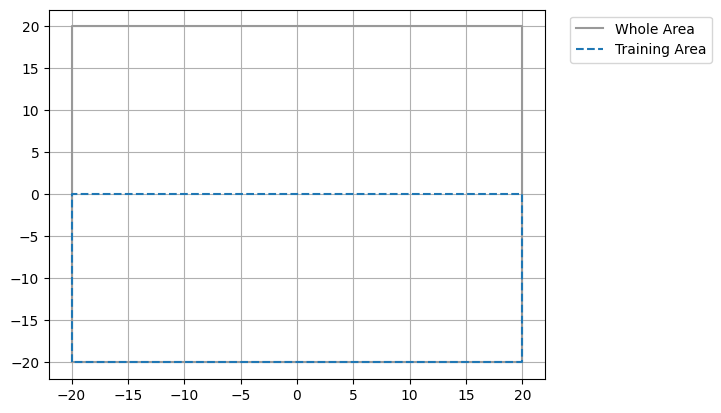

In [4]:
fig = builder.plot()

### Add object

In [5]:
builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)

fig = builder.add_object(
    Polygon([
        # Note: last point should be the same as the first one to close the polygon. If not, it will be added automatically
        Point(-15, -5),
        Point(-15, -10),
        Point(-5, -10),
        Point(-5, 5),
    ]),
    # Another object
    Polygon([
        Point(-5, -5),
        Point(-5, -10),
        Point(5, -10),
        Point(5, -5),
    ]),
).plot()

Error in callback <function flush_figures at 0x7efcc3906f20> (for post_execute):


KeyboardInterrupt: 

### Remove object

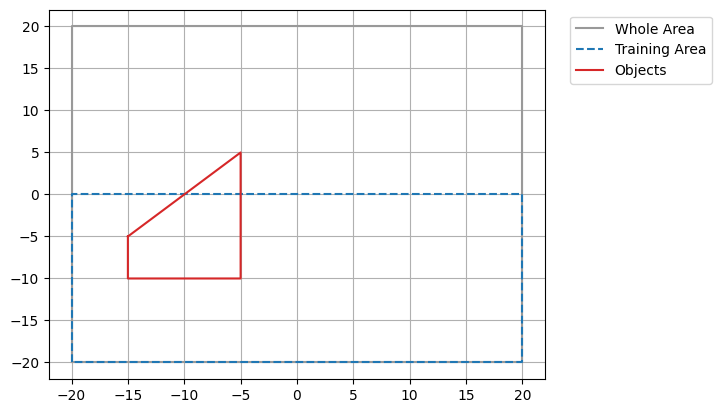

In [ ]:
fig = builder.remove_object(1).plot()

### Modify object

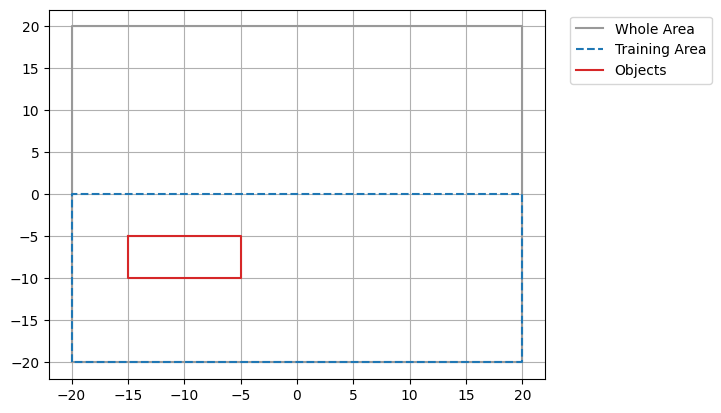

In [ ]:
object_ = builder[0]
points_x, points_y = object_.exterior.xy
points_x[-2], points_y[-2] = (-5, -5) # the last point is the same as the first one, so we change the second last point
builder[0] = Polygon(zip(points_x, points_y))
fig = builder.plot()

### Make some environment

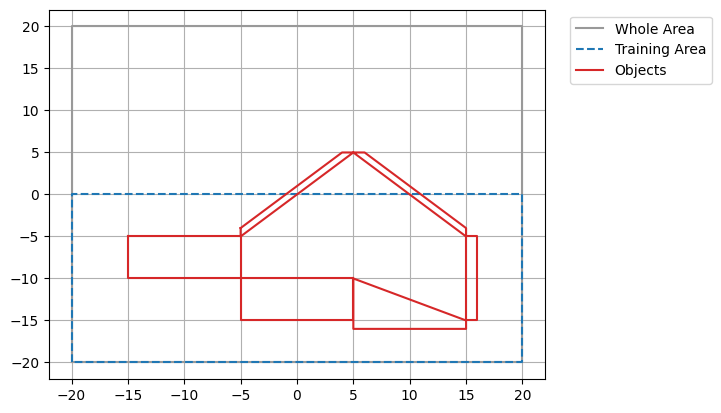

In [ ]:
fig = builder.add_object(
    Polygon([
        Point(-5, -4),
        Point(4, 5),
        Point(5, 5),
        Point(-5, -5)
    ]),
    Polygon([
        Point(5, 5),
        Point(6, 5),
        Point(15, -4),
        Point(15, -5)
    ]),
    Polygon([
        Point(15, -5),
        Point(16, -5),
        Point(16, -15),
        Point(15, -15)
    ]),
    Polygon([
        Point(15, -15),
        Point(15, -16),
        Point(5, -16),
        Point(5, -10)
    ]),
    Polygon([
        Point(5, -10),
        Point(5, -15),
        Point(-5, -15),
        Point(-5, -10)
    ])
).plot()

## Save environment

In [ ]:
builder.save('environment.ini')

### .ini file

```ini
[ExternalSources]
paths = 
variables = 

[GridBoundaries]
max_xy = 20
min_xy = -20
res = 0.3

[TrainingRectangle]
min_train_x = -20
min_train_y = -20
max_train_x = 20
max_train_y = 0

[BuildingBoundaries]
max_n_obj_points = 5
n_objects = 6
n_textures = 6

[Object1]
n_vertices = 5
object_x = -15.0, -15.0, -5.0, -5.0, -15.0
object_y = -5.0, -10.0, -10.0, 5.0, -5.0

[Object2]
n_vertices = 5
object_x = -5.0, 4.0, 5.0, -5.0, -5.0
object_y = -4.0, 5.0, 5.0, -5.0, -4.0

[Object3]
n_vertices = 5
object_x = 5.0, 6.0, 15.0, 15.0, 5.0
object_y = 5.0, 5.0, -4.0, -5.0, 5.0

[Object4]
n_vertices = 5
object_x = 15.0, 16.0, 16.0, 15.0, 15.0
object_y = -5.0, -5.0, -15.0, -15.0, -5.0

[Object5]
n_vertices = 5
object_x = 15.0, 15.0, 5.0, 5.0, 15.0
object_y = -15.0, -16.0, -16.0, -10.0, -15.0

[Object6]
n_vertices = 5
object_x = 5.0, 5.0, -5.0, -5.0, 5.0
object_y = -10.0, -15.0, -15.0, -10.0, -10.0
```

## Load environment

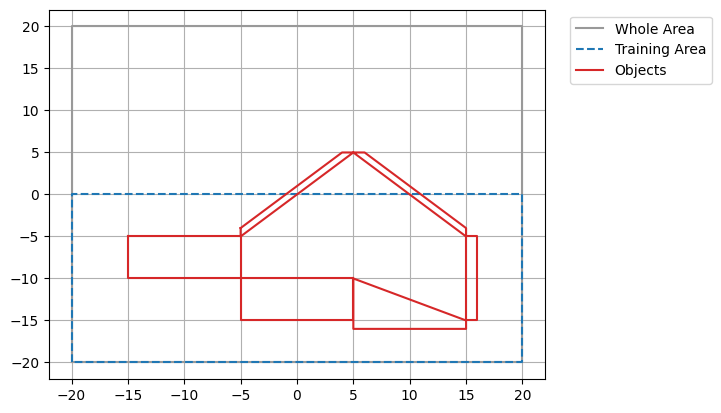

In [ ]:
builder = EnvironmentBuilder.load('environment.ini')
fig = builder.plot()

## Compile environment

In [ ]:
geometry = builder.build()()

### Check training space

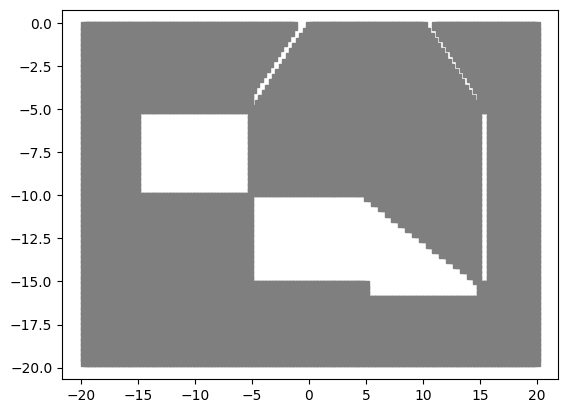

In [ ]:
fig = geometry.training_space.plot()

## Circular environment

### Function to create coordinates for bagel-shaped polygon

In [8]:
def generate_bagel_polygon(outer_radius: int, inner_radius: int, num_points: int, center: tuple[int, int] = (0, 0)):
    """
    Generate coordinates for a bagel-shaped polygon.

    Args:
        outer_radius (int): The radius of the outer circle.
        inner_radius (int): The radius of the inner circle.
        num_points (int): The number of points used to create the circular polygon.
        center (tuple[int, int], optional): The center coordinates of the bagel. Defaults to (0, 0).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the X and Y coordinates of the bagel-shaped polygon.

    Example:
        >>> outer_radius = 8
        >>> inner_radius = 4
        >>> num_points = 100
        >>> center = (2, 3)
        >>> x, y = generate_bagel_polygon(outer_radius, inner_radius, num_points, center)
        >>> plt.plot(x, y, label='Bagel Shape')
        >>> plt.show()
    """
    theta = np.linspace(0, 2*np.pi, num_points)

    outer_x = outer_radius * np.cos(theta)
    outer_y = outer_radius * np.sin(theta)

    inner_x = inner_radius * np.cos(theta)
    inner_y = inner_radius * np.sin(theta)

    # Connect the corresponding points of outer and inner circles
    x = np.concatenate((outer_x, inner_x[::-1])) + center[0]
    y = np.concatenate((outer_y, inner_y[::-1])) + center[1]

    return x, y


### Create environment

In [9]:
min_xy, max_xy = -20, 20 # create the box of size 20x20
min_train_x, max_train_x, min_train_y, max_train_y = -20, 20, -20, 0 # create the training area of size 20x10
res = 0.3 # set grid resolution

builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)

x, y = generate_bagel_polygon(10, 8, 50)

builder.add_object(
    Polygon(
        [Point(xi, yi) for xi, yi in zip(x, y)],
    )
)

### Visualize environment

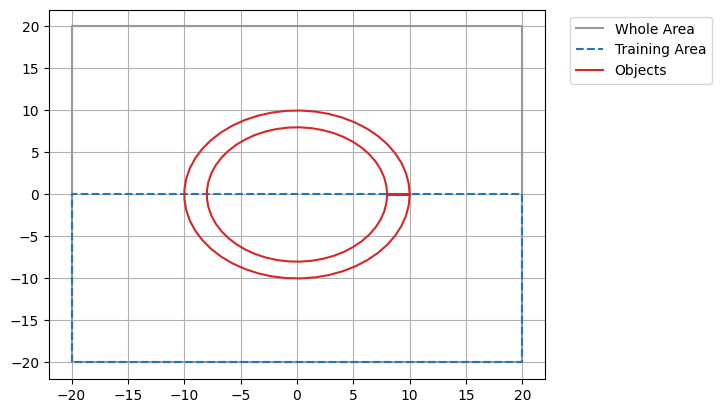

In [10]:
fig = builder.plot()

### Compile environment

In [11]:
geometry = builder.build()()

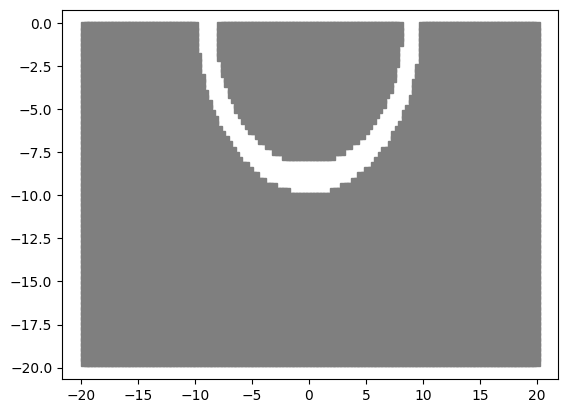

In [12]:
fig = geometry.training_space.plot()

In [ ]:
for x, y in zip(geometry.training_space.starting_points[:, 0],
    geometry.training_space.starting_points[:, 1]):
    print()